In [141]:
import numpy as np
from skimage import io
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import glob
import os
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray, rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median, threshold_otsu
from skimage.feature import canny

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Edges
from skimage.filters import sobel_h, sobel, sobel_v, roberts, prewitt
import pywt
from scipy.stats import skew, kurtosis, entropy
import math
from sklearn.decomposition import PCA

from sympy import fwht

from sklearn import metrics,svm
from sklearn.model_selection import train_test_split
import pickle
import sys
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import joblib
# from sklearn.svm import SVC
from scipy.linalg import hadamard 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import mahotas
import mahotas.demos

# DataSetPATH = "../input/fonts-dataset-cmp/fonts-dataset" # for kaggle
DataSetPATH = "./Dataset" # for local
DEBUG_PREPROCESSING=False

In [142]:
# Show the figures / plots inside the notebook
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ["(%d)" % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


def show_3d_image(img, title):
    fig = plt.figure()
    fig.set_size_inches((12, 8))
    ax = fig.gca(projection="3d")

    # Make data.
    X = np.arange(0, img.shape[0], 1)
    Y = np.arange(0, img.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    Z = img[X, Y]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(0, 8)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title(title)
    plt.show()


def show_3d_image_filtering_in_freq(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)

    img_in_freq = fftpack.fftshift(np.log(np.abs(img_in_freq) + 1))
    filtered_img_in_freq = fftpack.fftshift(np.log(np.abs(filtered_img_in_freq) + 1))

    show_3d_image(img_in_freq, "Original Image")
    show_3d_image(filtered_img_in_freq, "Filtered Image")


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align="center")


In [143]:
def ThresholdImage(image,Trace=False):
    img=image.copy()
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # use THRESH_OTSU to detect the threshold value automatically
    img = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    num_ones = np.count_nonzero(img)
    num_zeros = img.size - num_ones

    # it means that background is white and text is black
    if num_ones > num_zeros:
        img = cv.bitwise_not(img)
    if Trace:
        print(num_ones, num_zeros)
        show_images([img], ["Thresholded Image White background and Black text"])
    return img

In [144]:
def RemoveSaltPepperNoise(image,Trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = cv.medianBlur(img, 3)
    if Trace:
        show_images([img], ["Image after removing Salt and Pepper Noise"])
    return img

In [145]:
def DeskewImage(image,real,Trace=False):

    original = image.copy()
    img = image.copy()

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    opening = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    if Trace:
        show_images([opening], ["Opening Image"])
    # Dilate the text to make the text lines more obvious.
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (35, 35))
    dilate = cv.dilate(opening, kernel)
    if Trace:
        show_images([dilate], ["Dilated Image"])

    # Find all the contours based on the dilated image.
    contours, hierarchy = cv.findContours(
        dilate, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE
    )

    # show the contours
    if Trace:
        img = cv.drawContours(real, contours, -1, (0, 255, 0), 5)
        show_images([img], ["Contours"])

    # sort the contours based on the area
    contours = sorted(contours, key=cv.contourArea, reverse=False)
    # filter out the small contours
    contours = [cnt for cnt in contours if cv.contourArea(cnt)<0.9*img.shape[0]*img.shape[1]]  

    rect = cv.minAreaRect(contours[-1])
    angle = rect[-1]
    box = cv.boxPoints(rect)
    box = np.intp(box)

    if Trace:
        cv.drawContours(img,[box],0,(0,0,255),2)
        show_images([img], ["Rotated Rectangle"])

    # Calculate distances between consecutive points
    dis = []
    for i in range(len(box)):
        # Calculate the Euclidean distance between consecutive points
        dist = np.linalg.norm(box[i] - box[(i + 1) % len(box)])
        dis.append(dist)

    if Trace:
        print(f'Angle: {angle}')
        for (x,y) in box:
            print(f'({x},{y})')
        # for i, dist in enumerate(dis):
        #     print("Distance of side {}: {:.2f}".format(i + 1, dist))
    sortedx_box = sorted(box, key=lambda k: k[0])
    sortedy_box = sorted(box, key=lambda k: k[1])
    dis0 = np.linalg.norm(sortedy_box[-1] - sortedy_box[-2])
    dis1 = np.linalg.norm(sortedx_box[-1] - sortedx_box[-2])
    if Trace:
        print(f'sorted box')
        for (x,y) in box:
            print(f'sorted ({x},{y})')
        print(f"dis0: {dis0}")
        print(f"dis1: {dis1}")

    tolernace = 35
    if Trace:
        show_images([original])
    if angle >= 80:
        if dis0 > dis1 +  tolernace:
            angle = 0
            return original
        elif  dis1 > dis0 +  tolernace:
            angle = 90
        else:    
            angle = 0
            return original
    elif angle >=35 and angle < 55:
        angle = 45
    elif angle <= 10:
        if dis0 > dis1 + tolernace:
            angle = 0
            return original
        elif dis1 > dis0 + tolernace:
            angle = 90
        else:
            angle = 0
            return original

    height = original.shape[0]
    width = original.shape[1]
    m = cv.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    deskewed = cv.warpAffine(original, m, (width, height), borderValue=(0,0,0))
    if Trace:
        show_images([deskewed])

    return deskewed

In [146]:
def Preprocessing(image,Trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = RemoveSaltPepperNoise(img, Trace)
    # Threshold the image
    img = ThresholdImage(img, Trace)
    if np.count_nonzero(img) == 0:
        return None
    # Deskew the image
    deskewed = DeskewImage(img,image, Trace)
    return deskewed

In [165]:
# Function to calculate Edges Direction
def edges_direction(EDM1):
    # Find the maximum value and its coordinates in EDM1
  
    max_pos = np.unravel_index(np.argmax(EDM1), EDM1.shape)
    return  max_pos

# Function to calculate Homogeneity
def homogeneity(EDM1):
    total_sum = np.sum(EDM1)
    homogeneity_map = EDM1 / total_sum  # Normalize to get percentages
    return homogeneity_map

# Function to calculate Weight
def weight(EDM1, Iedge):
    # Count the number of black pixels in the edge image
    edge_pixel_count = np.sum(Iedge == 255)  # 255 for white edges in binary
    # EDM1(2,2) assuming indexing starts from 0, so EDM1[1, 1]
    weight = EDM1[1, 1] / edge_pixel_count
    return weight

# Function to calculate Pixel Regularity
def pixel_regularity(EDM1):
    edm_center = EDM1[1, 1]  # Assuming central pixel
    pixel_regularity_map = EDM1 / edm_center
    return pixel_regularity_map

# Function to calculate Edges Regularity
def edges_regularity(EDM2):
    edm_center = EDM2[1, 1]  # Assuming central pixel
    edges_regularity_map = EDM2 / edm_center
    return edges_regularity_map
 # Example random data

In [172]:
def calculate_edm1(edge_image):
    height, width = edge_image.shape
    edm1 = np.zeros((3, 3))  # Initialize a 3x3 matrix for EDM1
    
    # Loop through each pixel in the edge image
    for x in range(1, width - 1):
        for y in range(1, height - 1):
            if edge_image[y, x] == 255:  # Assuming white is edge
                # Check neighboring pixels and increase occurrence in EDM1
                # Based on the relationships given in the description
                # Center pixel (scoped pixel)
                edm1[1, 1] += 1  # 180 degrees
                
                # Other directions
                if edge_image[y, x + 1] == 255:
                    edm1[1, 2] += 1  # 0 degrees
                if edge_image[y - 1, x + 1] == 255:
                    edm1[0, 2] += 1  # 45 degrees
                if edge_image[y - 1, x] == 255:
                    edm1[0, 1] += 1  # 90 degrees
                if edge_image[y - 1, x - 1] == 255:
                    edm1[0, 0] += 1  # 135 degrees
                if edge_image[y, x - 1] == 255:
                    edm1[1, 0] += 1  # 180 degrees
                if edge_image[y + 1, x - 1] == 255:
                    edm1[2, 0] += 1  # 225 degrees
                if edge_image[y + 1, x] == 255:
                    edm1[2, 1] += 1  # 270 degrees
                if edge_image[y + 1, x + 1] == 255:
                    edm1[2, 2] += 1  # 315 degrees
    
    return edm1

# Function to calculate EDM2 based on sorted EDM1
def calculate_edm2(edm1):
    # Flatten and sort EDM1 in descending order
    sorted_edm1 = np.sort(edm1.flatten())[::-1]  # Descending order
    edm2 = np.zeros_like(edm1)  # Initialize EDM2
    
    # Reorder EDM2 based on sorted EDM1 values
    for i, val in enumerate(sorted_edm1):
        # Fill EDM2 with the sorted values
        row, col = np.unravel_index(i, edm1.shape)
        edm2[row, col] = val
    
    return edm2
def train(image):
    edge_image = cv.Canny(image, 100, 200)  # Canny edge detection

    # Calculate EDM1 and EDM2
    edm1 = calculate_edm1(edge_image)
    edm2 = calculate_edm2(edm1)
    return edm1,edm2,edge_image

In [173]:

def extract_dwt_features(corrected):
 
    EDM1,EDM2,edges=train(corrected)
    # Extract features from DWT coefficients
    features = []
    features.append(edges_direction(EDM1))
    features.append(homogeneity(EDM1))
    features.append(weight(EDM1,edges))
    features.append(pixel_regularity(EDM1))
    features.append(edges_regularity(EDM2))
    corrected[corrected == 0]   = 1
    # Convert white spots to zeros 
    corrected[corrected == 255] = 0
  
    horizontal_projection = np.sum(corrected, axis = 1)  
    for num in horizontal_projection:
       features.append(num)
   
    moments=cv.moments(corrected)
    invariant_moments=cv.HuMoments(moments)
    moments_array = np.array(list(moments.values()))

    moments_array = np.array(list(moments.values())).flatten()
    if moments_array.ndim > 1:
        moments_array = moments_array.flatten()

    if invariant_moments.ndim > 1:
        invariant_moments = invariant_moments.flatten()



    
    features = np.concatenate((moments_array, invariant_moments))

    return features




In [174]:
# destination = "./Corrected/Scheherazade New"
# if not os.path.exists(destination):
#     os.makedirs(destination)

Scheherazade=[]
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Scheherazade New/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        Scheherazade.append(extract_dwt_features(corrected))
        # if DEBUG_PREPROCESSING:
        #     io.imsave(f"{destination}/{filename}", corrected, check_contrast=False)

100%|██████████| 1000/1000 [1:53:31<00:00,  6.81s/it] 


In [175]:
# destination = "./Corrected/IBM Plex Sans Arabic"
# if not os.path.exists(destination):
#     os.makedirs(destination)

IBM = []
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/IBM Plex Sans Arabic/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        IBM.append(extract_dwt_features(corrected))
        # if DEBUG_PREPROCESSING:
        #     io.imsave(
        #         f"./Corrected/IBM Plex Sans Arabic/{filename}",
        #         corrected,
        #         check_contrast=False,
        #     )

100%|██████████| 1000/1000 [1:38:42<00:00,  5.92s/it]


In [176]:
# destination = "./Corrected/Marhey"
# if not os.path.exists(destination):
#     os.makedirs(destination)

Marhey=[]
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Marhey/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        Marhey.append(extract_dwt_features(corrected))
        # if DEBUG_PREPROCESSING:
        #     io.imsave(
        #         f"./Corrected/Marhey/{filename}",
        #         corrected,
        #         check_contrast=False,
        #     )

 40%|███▉      | 397/1000 [47:05<1:07:54,  6.76s/it]

In [152]:
# destination = "./Corrected/Lemonada"
# if not os.path.exists(destination):
#     os.makedirs(destination)

Lemonada=[]
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Lemonada/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        Lemonada.append(extract_dwt_features(corrected))
        # if DEBUG_PREPROCESSING:
        #     io.imsave(
        #         f"./Corrected/Lemonada/{filename}",
        #         corrected,
        #         check_contrast=False,
        #     )

100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]


In [153]:
Lemonada = np.array(Lemonada)
IBM = np.array(IBM)
Marhey = np.array(Marhey)
Scheherazade = np.array(Scheherazade)


print(Lemonada.shape)
print(IBM.shape)
print(Marhey.shape)
print(Scheherazade.shape)


pca = PCA(n_components=20)
Lemonada_pca = pca.fit_transform(Lemonada)
IBM_pca = pca.fit_transform(IBM)
Marhey_pca = pca.fit_transform(Marhey)
Scheherazade_pca = pca.fit_transform(Scheherazade)

# Save the PCA object
joblib.dump(pca, "pca_model.pkl")

print(Lemonada_pca.shape)
print(IBM_pca.shape)
print(Marhey_pca.shape)
print(Scheherazade_pca.shape)

Data = np.concatenate((Lemonada_pca, IBM_pca, Marhey_pca, Scheherazade_pca), axis=0)
labels = np.concatenate(
    (np.zeros(Lemonada.shape[0]), np.ones(IBM.shape[0]), np.ones(Marhey.shape[0]) * 2, np.ones(Scheherazade.shape[0]) * 3)
)
X_train, X_test, y_train, y_test = train_test_split(
    Data, labels, test_size=0.4, random_state=42
)

x_validation, x_test, y_validation, y_test = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

(997, 31)
(1000, 31)
(1000, 31)
(1000, 31)
(997, 20)
(1000, 20)
(1000, 20)
(1000, 20)


In [154]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
with open("moments_knn_classifier.pkl", "wb") as file:
    pickle.dump(knn, file)

87.85982478097623


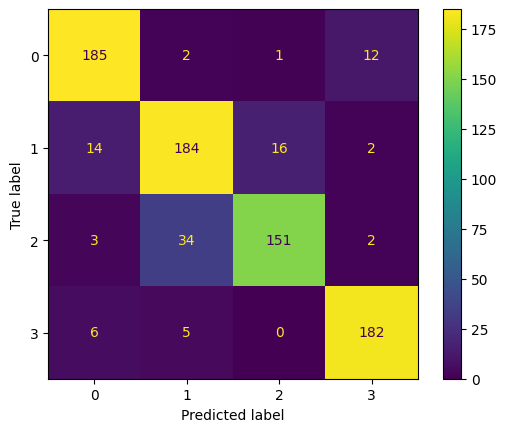

In [155]:
knn = pickle.load(open("moments_knn_classifier.pkl", "rb"))


y_pred = knn.predict(x_validation)


print(accuracy_score(y_validation, y_pred) * 100)

confusion_matrix = metrics.confusion_matrix(y_validation, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=[0, 1, 2, 3]
)
cm_display.plot()
plt.show()

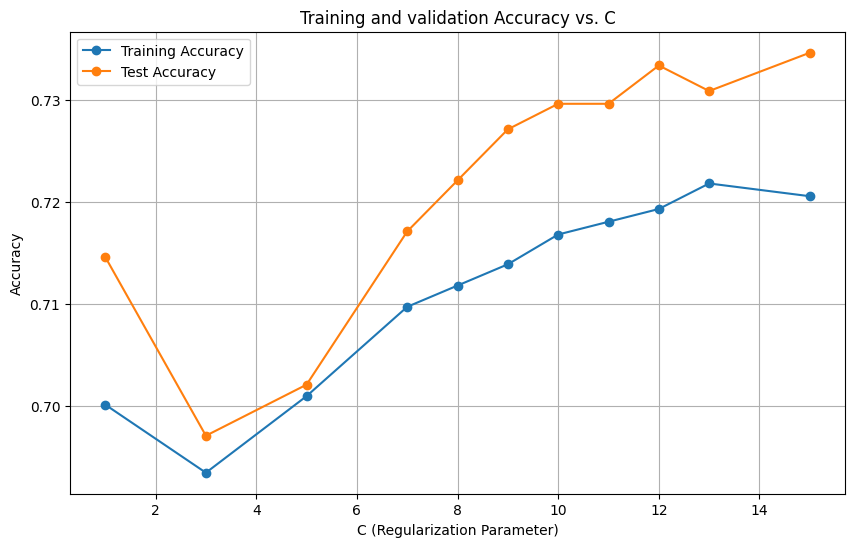

In [156]:
# Varying values of C
C_values = [1,3,5,7,8,9,10,11,12,13,15]

# Lists to store training and test accuracies
train_accuracies = []
validation_accuracies = []

# Train SVM models with different values of C
for C in C_values:
    model = SVC(kernel="rbf", C=C,gamma='scale')
    model.fit(X_train, y_train)

    # Compute training accuracy
    train_accuracy = model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Compute test accuracy
    validation_accuracy = model.score(x_validation, y_validation)
    validation_accuracies.append(validation_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accuracies, marker="o", label="Training Accuracy")
plt.plot(C_values, validation_accuracies, marker="o", label="Test Accuracy")
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Accuracy")
plt.title("Training and validation Accuracy vs. C")
plt.legend()
plt.grid(True)
plt.show()

In [157]:
# Define the parameter grid
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['rbf'],
              'gamma': ['scale', 'auto', 0.1, 1, 10],
                }
# Create an SVM model
svm = SVC()

# Perform a grid search
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [158]:
#  make a prediction with probability true to debug



svm_classifier = SVC(decision_function_shape="ovr", kernel="rbf",gamma='scale' , probability=True,C=10)
svm_classifier.fit(X_train, y_train)
with open( 'moments_svm_classifier.pkl', 'wb') as file:
    pickle.dump(svm_classifier, file)

Model Accuracy 72.96620775969961
F1 Score: 72.27611415140045


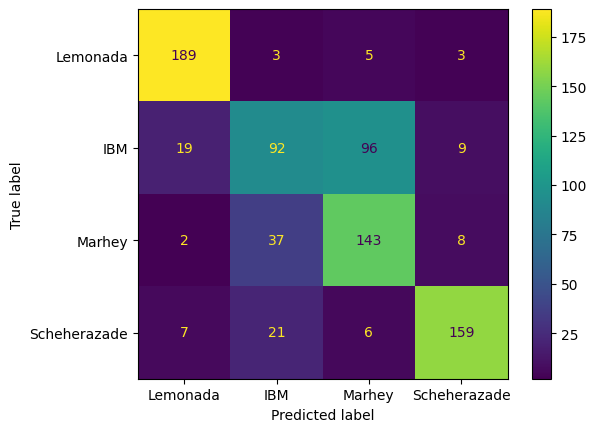

In [159]:
svm_classifier = pickle.load(open("moments_svm_classifier.pkl", "rb"))

y_pred = svm_classifier.predict(x_validation)

print("Model Accuracy",accuracy_score(y_validation, y_pred) * 100)

# Compute F1 score (meaning that it is not biased)
f1 = f1_score(y_validation, y_pred, average="weighted")
print("F1 Score:", f1 * 100)


confusion_matrix = metrics.confusion_matrix(y_validation, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=["Lemonada", 'IBM', 'Marhey', 'Scheherazade']
)
cm_display.plot()
plt.show()

72.0


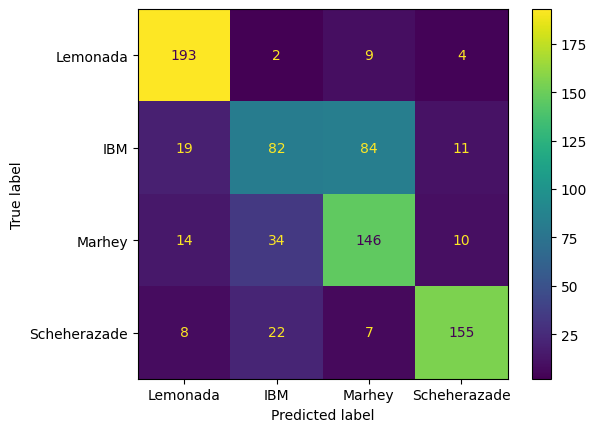

In [160]:
y_pred = svm_classifier.predict(x_test)

print(accuracy_score(y_test, y_pred) * 100)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=["Lemonada", "IBM", "Marhey", "Scheherazade"],
)
cm_display.plot()
plt.show()

In [161]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=40,
                                       n_estimators=200, oob_score=True)


classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, n_estimators=200, n_jobs=-1,
                       oob_score=True, random_state=42)

97.0


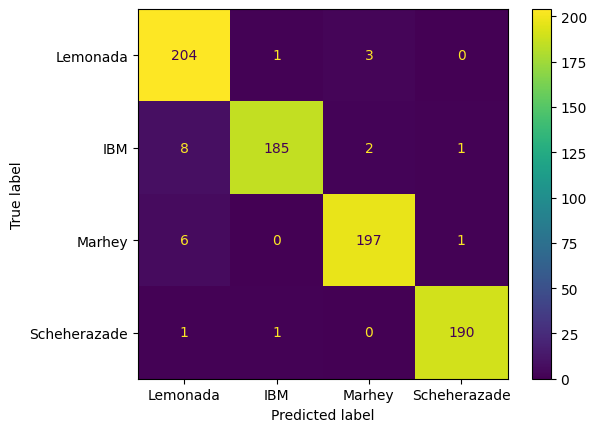

In [162]:
y_pred = classifier_rf.predict(x_test)

print(accuracy_score(y_test, y_pred) * 100)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=["Lemonada", "IBM", "Marhey", "Scheherazade"],
)
cm_display.plot()
plt.show()

100.0


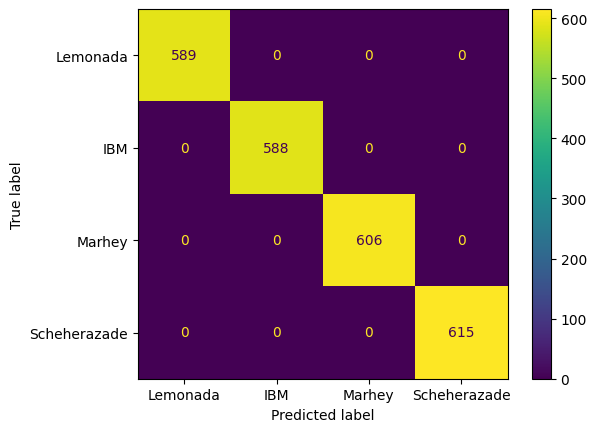

In [163]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,  # Number of boosting rounds
    max_depth=40,  # Maximum tree depth
    learning_rate=0.1,  # Learning rate for gradient boosting
    objective='multi:softmax',  # Multi-class objective
    num_class=4,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_train)

print(accuracy_score(y_train, y_pred) * 100)

confusion_matrix = metrics.confusion_matrix(y_train, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=["Lemonada", "IBM", "Marhey", "Scheherazade"],
)
cm_display.plot()
plt.show()

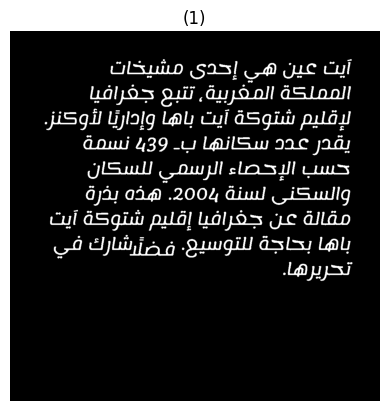

(1, 20)
[3]


In [164]:

filepath = glob.glob(f"{DataSetPATH}/Lemonada/5.jpeg")[0]  # Ensure only one filepath
filename = os.path.basename(filepath)

img = io.imread(filepath)  # Load the image

corrected = Preprocessing(img)
show_images([corrected])
features=extract_dwt_features(corrected)

features_reshaped = features.reshape(1, -1)  # Reshape to ensure it's 2D with 1 sample



f=pca.transform(features_reshaped)
print(f.shape)
y_pred = xgb_clf.predict(f)
print(y_pred)

